In [30]:
import pandas as pd
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import operator
import re
from random import sample
from netgraph import Graph
import gravis as gv

# Load data

In [90]:
meta = pd.read_csv("data/meta.csv")
meta = meta.loc[meta["nodes"]>100]


In [91]:

# Function to check if a string is a valid name
stopwords = ["unknown","tba","tbd"]
def is_valid_name(name):
    # You can modify this function based on your criteria for valid names
    cleaned_name = re.sub(r'[^a-zA-Z]', '', name)

    if operator.contains(stopwords,cleaned_name):
        return False
    return cleaned_name.isalpha()

def clean_text(actorlist):
# Split elements by "and" and filter out invalid names
    split_names = []
    for item in actorlist:
        names = item.split(" ")[:2]
        if len(names)<2:
            pass
        else:
            name = names[0] + " "+ names[1]
            if is_valid_name(name):
                split_names.append(name)
                

    # Overwrite the original names_list with split and filtered names
    return set(split_names)
def keep_important_nodes(edge_df,attr_df):
    nodes = pd.concat([edge_df['from'], edge_df['to']]).unique()
    node_counts = []
    for node in nodes:
        # Count how many times the node appears in 'from' and 'to' columns
        count = ((edge_df['from'] == node) | (edge_df['to'] == node)).sum()
        # Append to the DataFrame
        node_counts.append(count)

    # Sort the DataFrame by node for better visualization (optional)
    nodedf = pd.DataFrame(columns=["node","count"])
    nodedf["node"] = nodes
    nodedf["count"] = node_counts
    topnodes = list(nodedf.sort_values("count",ascending=False).head(50)["node"])
    return attr_df.loc[attr_df["id"].isin(list(topnodes))]

In [92]:
actordict = {}
for id in tqdm(meta["id"]):
    #print(id)
    actorvar = meta.loc[meta["id"] == id,"actor_variable"].values[0]
    if actorvar == 'no':
        pass
    else:
        edge_data = pd.read_csv("data/{}/edges.csv".format(id))
        temp_data = pd.read_csv("data/{}/attributes.csv".format(id))
        temp_data = keep_important_nodes(edge_data,temp_data)
        actorlist = clean_text([a.lower() for a in temp_data[actorvar].dropna().to_list()])
        actordict[id] = actorlist


100%|██████████| 96/96 [01:40<00:00,  1.04s/it]


In [93]:
# Create network
# Create an empty bipartite graph
B = nx.Graph()

# Add nodes from the first partition (keys)
B.add_nodes_from(actordict.keys(), bipartite=0)

# Add nodes from the second partition (values)
B.add_nodes_from([node for nodes in actordict.values() for node in nodes], bipartite=1)

# Add edges between the two partitions
for node, neighbors in tqdm(actordict.items()):
    B.add_edges_from((node, neighbor) for neighbor in neighbors)

100%|██████████| 84/84 [00:00<00:00, 28093.58it/s]


In [94]:
series_graph = nx.projected_graph(B,nodes = list(actordict.keys()),multigraph=True)
edge_df = nx.to_pandas_edgelist(series_graph,edge_key="actor")
#edge_df.head()
weight_edge_df = edge_df.groupby(["source","target"])["actor"].agg('count').reset_index()
weight_edge_df=weight_edge_df.rename(columns={"actor":"weight"})

# Create network

In [169]:
weighted_graph = nx.from_pandas_edgelist(weight_edge_df,edge_attr=True)
comms = nx.community.louvain_communities(weighted_graph,weight="weight",seed=42,resolution=0.7)

In [170]:
len(comms)

5

In [171]:
communities = {}
for i, comm in enumerate(comms):
    for node in comm:
        communities[node] = i
# Define colors for communities
num_communities = max(communities.values())
color_map = plt.cm.get_cmap('Set1', num_communities)
node_colors = [color_map(communities[node] / num_communities) for node in weighted_graph.nodes()]
nodes = weighted_graph.nodes


C:\Users\tomi\AppData\Local\Temp\ipykernel_30388\1013507485.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('Set1', num_communities)


In [145]:
community_positions = {
    1: (1.5, 1.5),
    2: (1, 1),
    3: (-1, 1),
    4: (1.5, -1.5),
    5: (-1.5, -1.5),
    6: (0, 2),
    7: (0, -2),
    8: (2, 0),
    0: (-2, 0)
}


c:\Users\tomi\AppData\Local\Programs\Python\Python311\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


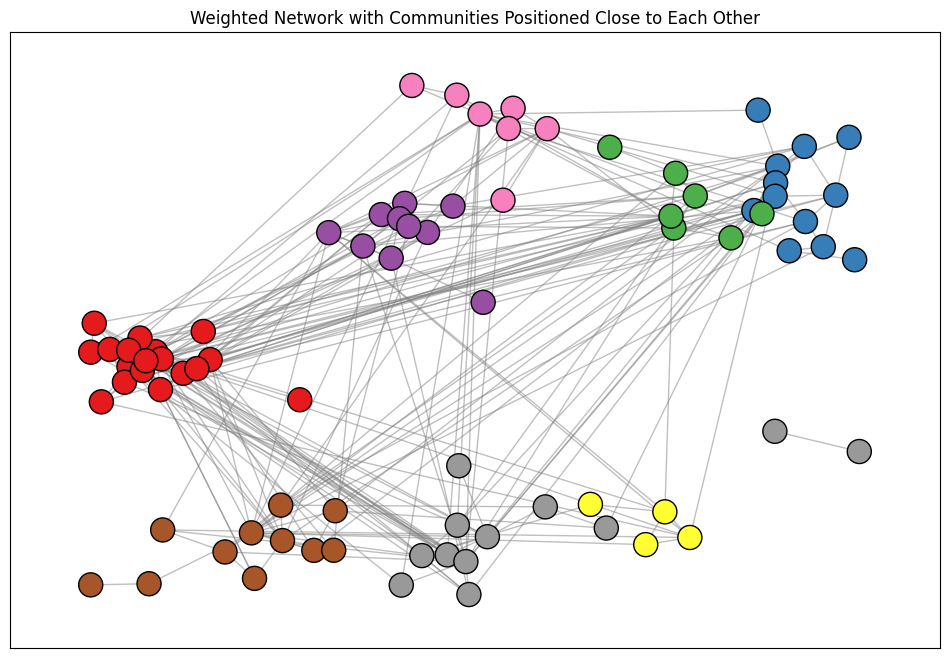

In [147]:
pos = nx.spring_layout(weighted_graph, k = 0.5,seed=42)
# Plot the main graph
plt.figure(figsize=(12, 8))
#nx.draw(weighted_graph, pos, node_size=200, node_color=node_colors, cmap=color_map, edge_color='gray', with_labels=False)

# Plot nodes for each community with custom positions
for node, comm in communities.items():
    if comm in community_positions:
        pos[node] += community_positions[comm]
nx.draw_networkx_nodes(weighted_graph, pos, node_size=300, node_color=node_colors, cmap=color_map, edgecolors='black',)
nx.draw_networkx_edges(weighted_graph, pos, edge_color='gray', alpha=0.5)

plt.title("Weighted Network with Communities Positioned Close to Each Other")
plt.show()

c:\Users\tomi\AppData\Local\Programs\Python\Python311\Lib\site-packages\netgraph\_node_layout.py:1550: UserWarning: Graph contains a single community. Unable to compute a community layout. Computing spring layout instead.
  warnings.warn("Graph contains a single community. Unable to compute a community layout. Computing spring layout instead.")
c:\Users\tomi\AppData\Local\Programs\Python\Python311\Lib\site-packages\netgraph\_node_layout.py:1024: RuntimeWarning: invalid value encountered in divide
  directions = deltas / magnitudes[:, np.newaxis]
c:\Users\tomi\AppData\Local\Programs\Python\Python311\Lib\site-packages\netgraph\_edge_layout.py:978: RuntimeWarning: invalid value encountered in divide
  displacement = compatibility * delta / distance_squared[..., None]
c:\Users\tomi\AppData\Local\Programs\Python\Python311\Lib\site-packages\netgraph\_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


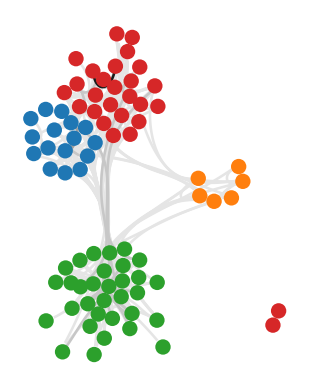

In [159]:
community_to_color = {
    0 : 'tab:blue',
    1 : 'tab:orange',
    2 : 'tab:green',
    3 : 'tab:red',
    4 : 'tab:red'
}
node_color = {node: community_to_color[community_id] for node, community_id in communities.items()}

Graph(weighted_graph,
      node_color=node_color, node_edge_width=0, edge_alpha=1,
      node_layout='community', node_layout_kwargs=dict(node_to_community=communities),
      edge_layout='bundled', edge_layout_kwargs=dict(k=2000),
)

plt.show()

In [161]:
asd = weight_edge_df["weight"]

In [162]:
import gravis as gv

In [164]:
gv.d3(weighted_graph, 
      #edge_size_data_source='weight', 
      use_edge_size_normalization=True)

In [176]:
def assign_properties(g,communities):
    # Centrality calculation
    node_centralities = nx.eigenvector_centrality(g)
    edge_centralities = nx.edge_betweenness_centrality(g)

    # Community detection
    #communities = nx.algorithms.community.greedy_modularity_communities(g)
    # Graph properties
    g.graph['node_border_size'] = 1.5
    g.graph['node_border_color'] = 'white'
    g.graph['edge_opacity'] = 0.9

    # Node properties: Size by centrality, shape by size, color by community
    colors = ['red', 'blue', 'green', 'orange', 'yellow',
              #'pink', 'brown', 'cyan', 'magenta', 'violet'
              ]
    for node_id in g.nodes:
        node = g.nodes[node_id]
        node['size'] = 10 + node_centralities[node_id] * 10
        #node['shape'] = 'rectangle' if node['size'] > 30 else 'circle'
        for community_counter, community_members in enumerate(communities):
            if node_id in community_members:
                break
        node['color'] = colors[community_counter % len(colors)]

    # Edge properties: Size by centrality, color by community (within=community color, between=black)
    for edge_id in g.edges:
        edge =  g.edges[edge_id]
        source_node = g.nodes[edge_id[0]]
        target_node = g.nodes[edge_id[1]]
        #edge['size'] = edge_centralities[edge_id] * 100
        #edge['color'] = source_node['color'] if source_node['color'] == target_node['color'] else 'black'


In [177]:
assign_properties(weighted_graph,communities)

In [178]:
gv.d3(weighted_graph, zoom_factor=1)